## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_classes = 10

In [ ]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

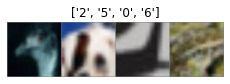

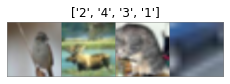

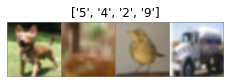

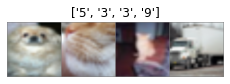

In [ ]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn()

In [ ]:
vgg= vgg.to('cuda:0')

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.28
Iteration: 100/3125, Loss: 4.58
Iteration: 200/3125, Loss: 2.76
Iteration: 300/3125, Loss: 2.52
Iteration: 400/3125, Loss: 2.25
Iteration: 500/3125, Loss: 2.30
Iteration: 600/3125, Loss: 2.32
Iteration: 700/3125, Loss: 2.30
Iteration: 800/3125, Loss: 2.30
Iteration: 900/3125, Loss: 2.29
Iteration: 1000/3125, Loss: 2.30
Iteration: 1100/3125, Loss: 2.30
Iteration: 1200/3125, Loss: 2.32
Iteration: 1300/3125, Loss: 2.30
Iteration: 1400/3125, Loss: 2.30
Iteration: 1500/3125, Loss: 2.30
Iteration: 1600/3125, Loss: 2.31
Iteration: 1700/3125, Loss: 2.30
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.30
Iteration: 2000/3125, Loss: 2.30
Iteration: 2100/3125, Loss: 2.31
Iteration: 2200/3125, Loss: 2.32
Iteration: 2300/3125, Loss: 2.30
Iteration: 2400/3125, Loss: 2.31
Iteration: 2500/3125, Loss: 2.29
Iteration: 2600/3125, Loss: 2.30
Iteration: 2700/3125, Loss: 2.30
Iteration: 2800/3125, Loss: 2.30
Iteration: 2900/3125, Loss: 2.31
Iteration: 3000/3125, 

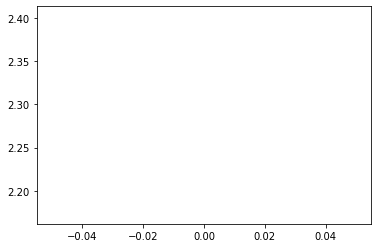

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg.to(device)
summary(vgg,(3,224,224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.34
Iteration: 100/3125, Loss: 1.48
Iteration: 200/3125, Loss: 1.76
Iteration: 300/3125, Loss: 1.32
Iteration: 400/3125, Loss: 1.47
Iteration: 500/3125, Loss: 1.97
Iteration: 600/3125, Loss: 1.34
Iteration: 700/3125, Loss: 2.13
Iteration: 800/3125, Loss: 1.46
Iteration: 900/3125, Loss: 2.71
Iteration: 1000/3125, Loss: 2.69
Iteration: 1100/3125, Loss: 2.37
Iteration: 1200/3125, Loss: 1.74
Iteration: 1300/3125, Loss: 2.26
Iteration: 1400/3125, Loss: 2.36
Iteration: 1500/3125, Loss: 1.92
Iteration: 1600/3125, Loss: 1.58
Iteration: 1700/3125, Loss: 3.09
Iteration: 1800/3125, Loss: 2.56
Iteration: 1900/3125, Loss: 2.42
Iteration: 2000/3125, Loss: 1.47
Iteration: 2100/3125, Loss: 1.53
Iteration: 2200/3125, Loss: 2.29
Iteration: 2300/3125, Loss: 1.03
Iteration: 2400/3125, Loss: 1.74
Iteration: 2500/3125, Loss: 1.71
Iteration: 2600/3125, Loss: 1.85
Iteration: 2700/3125, Loss: 3.11
Iteration: 2800/3125, Loss: 1.88
Iteration: 2900/3125, Loss: 1.71
Iteration: 3000/3125, 

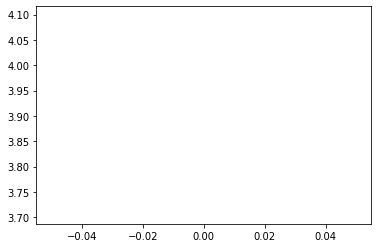

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### With model copies

In [ ]:
import copy

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 18.67
Iteration: 0/3125, Loss: 18.67
Min loss 17.50
Min loss 17.00
Min loss 14.74
Min loss 14.62
Min loss 12.40
Min loss 10.66
Min loss 9.99
Min loss 9.60
Iteration: 100/3125, Loss: 13.87
Min loss 8.35
Iteration: 200/3125, Loss: 14.72
Min loss 8.07
Iteration: 300/3125, Loss: 12.00
Min loss 7.04
Iteration: 400/3125, Loss: 22.86
Iteration: 500/3125, Loss: 17.09
Iteration: 600/3125, Loss: 15.88
Iteration: 700/3125, Loss: 23.00
Iteration: 800/3125, Loss: 12.98
Iteration: 900/3125, Loss: 29.67
Iteration: 1000/3125, Loss: 15.05
Min loss 6.40
Iteration: 1100/3125, Loss: 19.05
Min loss 5.75
Iteration: 1200/3125, Loss: 12.95
Min loss 5.42
Iteration: 1300/3125, Loss: 13.43
Iteration: 1400/3125, Loss: 14.07
Iteration: 1500/3125, Loss: 22.29
Iteration: 1600/3125, Loss: 16.30
Iteration: 1700/3125, Loss: 22.30
Iteration: 1800/3125, Loss: 12.37
Iteration: 1900/3125, Loss: 21.12
Iteration: 2000/3125, Loss: 21.01
Iteration: 2100/3125, Loss: 12.79
Iteration: 2200/3125, Loss: 14.13
Iteration: 23

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

14.02 13.87


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [ ]:
resnet = models.resnet18(pretrained=True)

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.56
Iteration: 0/3125, Loss: 2.56
Min loss 2.42
Min loss 2.27
Min loss 2.17
Min loss 2.12
Min loss 2.04
Min loss 1.88
Min loss 1.82
Min loss 1.67
Min loss 1.65
Min loss 1.58
Min loss 1.35
Iteration: 100/3125, Loss: 2.15
Min loss 1.16
Iteration: 200/3125, Loss: 1.69
Min loss 1.04
Min loss 1.03
Iteration: 300/3125, Loss: 1.03
Min loss 0.96
Iteration: 400/3125, Loss: 1.29
Min loss 0.90
Min loss 0.86
Iteration: 500/3125, Loss: 1.75
Iteration: 600/3125, Loss: 1.51
Min loss 0.84
Iteration: 700/3125, Loss: 1.33
Min loss 0.59
Iteration: 800/3125, Loss: 1.51
Iteration: 900/3125, Loss: 0.69
Iteration: 1000/3125, Loss: 1.18
Min loss 0.56
Iteration: 1100/3125, Loss: 1.73
Iteration: 1200/3125, Loss: 1.93
Iteration: 1300/3125, Loss: 1.23
Iteration: 1400/3125, Loss: 1.28
Iteration: 1500/3125, Loss: 1.18
Iteration: 1600/3125, Loss: 1.32
Iteration: 1700/3125, Loss: 1.80
Iteration: 1800/3125, Loss: 1.11
Iteration: 1900/3125, Loss: 1.71
Iteration: 2000/3125, Loss: 1.01
Iteration: 2100/3125, Los

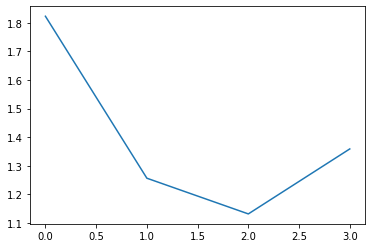

In [ ]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

56.21 55.99


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [ ]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
inception= inception.to(device)
summary(inception,(3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

In [ ]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.22
Iteration: 0/3125, Loss: 3.22
Min loss 3.08
Min loss 3.00
Min loss 2.98
Min loss 2.90
Min loss 2.83
Min loss 2.78
Min loss 2.74
Min loss 2.74
Min loss 2.62
Min loss 2.61
Min loss 2.60
Min loss 2.51
Iteration: 100/3125, Loss: 2.59
Min loss 2.41
Min loss 2.37
Min loss 2.33
Min loss 2.17
Iteration: 200/3125, Loss: 2.42
Min loss 2.15
Min loss 2.12
Min loss 2.03
Min loss 1.92
Min loss 1.90
Iteration: 300/3125, Loss: 2.47
Min loss 1.80
Iteration: 400/3125, Loss: 1.84
Min loss 1.76
Min loss 1.71
Min loss 1.69
Iteration: 500/3125, Loss: 2.31
Iteration: 600/3125, Loss: 2.07
Min loss 1.63
Iteration: 700/3125, Loss: 1.84
Min loss 1.51
Iteration: 800/3125, Loss: 1.84
Iteration: 900/3125, Loss: 2.32
Min loss 1.47
Iteration: 1000/3125, Loss: 1.70
Min loss 1.36
Iteration: 1100/3125, Loss: 2.56
Iteration: 1200/3125, Loss: 1.58
Iteration: 1300/3125, Loss: 2.10
Min loss 1.36
Iteration: 1400/3125, Loss: 1.72
Min loss 1.23
Iteration: 1500/3125, Loss: 2.18
Min loss 1.23
Iteration: 1600/3125, 

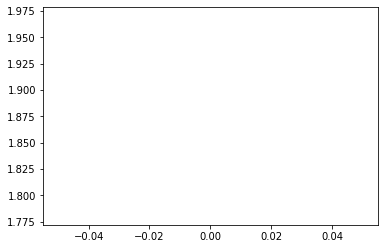

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.322 45.67


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one

# Pre-training with custom layers


In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG_custom(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG_custom, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        #x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG_custom(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)



def vgg11_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)



def vgg13(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)



def vgg13_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)



def vgg16(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)



def vgg16_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)



def vgg19(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)



def vgg19_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

In [ ]:
vgg= vgg16_bn(pretrained= True)

In [ ]:
from torchsummary import summary
vgg= vgg.to(device)


In [ ]:
class Custom_classifier(nn.Module):
    def __init__(self):
        super(Custom_classifier,self).__init__()
        self.cnn_model= nn.Sequential(nn.Conv2d(512,128,1),       # (N,512,7,7) -> (N, 128,7,7)
                                      nn.Tanh(),
                                      nn.Conv2d(128,64,1),        # (N,128,7,7) -> (N,64,7,7)
                                      nn.Tanh(),
                                      nn.AvgPool2d(2, stride= 2 ), # (N,64,7,7) -> (N, 64, 3,3)
                                      nn.Tanh(),
                                      nn.Conv2d(64,16,1),          # (N, 64,3,3) -> (N, 16,3,3 )
                                      nn.ReLU(),
                                      nn.Conv2d(16,8,1)           # (N, 16,3,3  ) -> (N, 8 ,3, 3 )
                                      )
        self.fc_model=nn.Sequential(nn.Linear(72,32),
                              nn.Tanh(),
                              nn.Linear(32,10),
                              )
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x


In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
my_net= Custom_classifier()
vgg.classifier= my_net
my_net

Custom_classifier(
  (cnn_model): Sequential(
    (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Tanh()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Tanh()
    (6): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc_model): Sequential(
    (0): Linear(in_features=72, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)


torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Size([64, 128, 1, 1])
torch.Size([64])
torch.Size([16, 64, 1, 1])
torch.Size([16])
torch.Size([8, 16, 1, 1])
torch.Size([8])
torch.Size([32, 72])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
vgg

VGG_custom(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(1

In [ ]:
vgg= vgg.to(device)
summary(vgg,(3,224,224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.26
Iteration: 100/3125, Loss: 2.32
Iteration: 200/3125, Loss: 2.32
Iteration: 300/3125, Loss: 2.30
Iteration: 400/3125, Loss: 2.28
Iteration: 500/3125, Loss: 2.31
Iteration: 600/3125, Loss: 2.29
Iteration: 700/3125, Loss: 2.30
Iteration: 800/3125, Loss: 2.32
Iteration: 900/3125, Loss: 2.30
Iteration: 1000/3125, Loss: 2.31
Iteration: 1100/3125, Loss: 2.31
Iteration: 1200/3125, Loss: 2.12
Iteration: 1300/3125, Loss: 2.09
Iteration: 1400/3125, Loss: 2.08
Iteration: 1500/3125, Loss: 1.56
Iteration: 1600/3125, Loss: 2.01
Iteration: 1700/3125, Loss: 1.77
Iteration: 1800/3125, Loss: 2.14
Iteration: 1900/3125, Loss: 2.27
Iteration: 2000/3125, Loss: 1.85
Iteration: 2100/3125, Loss: 2.04
Iteration: 2200/3125, Loss: 2.04
Iteration: 2300/3125, Loss: 1.83
Iteration: 2400/3125, Loss: 1.77
Iteration: 2500/3125, Loss: 1.99
Iteration: 2600/3125, Loss: 1.87
Iteration: 2700/3125, Loss: 2.18
Iteration: 2800/3125, Loss: 1.97
Iteration: 2900/3125, Loss: 1.53
Iteration: 3000/3125, 

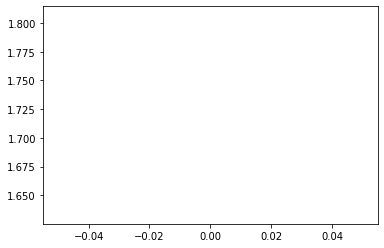

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()